## Section 4. Model Architecture & Training for RQ2

> **_Can the proposed "Pseudo-RGB" enhancement technique yield statistically significant improvements when applied to the leakage-corrected, rigorous baseline established in RQ1?_**
> 

Load TensorFlow and check GPU availability as pre-flight check.

In [1]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

2025-12-19 01:45:15.469692: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 01:45:15.487625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766079915.510979   84737 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766079915.518330   84737 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766079915.537062   84737 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Get the version of TensorFlow, related version information, and available GPU.

In [2]:
print("Tensorflow Version: ", tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print("Numbers of GPU Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", len(gpus))
for gpu in gpus:
    print("Name:", gpu.name, "; Type:", gpu.device_type)
    tf.config.experimental.set_memory_growth(gpu, True)

Tensorflow Version:  2.19.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Numbers of GPU Available:  1
Num GPUs Available:  1
Name: /physical_device:GPU:0 ; Type: GPU


Since the on-prem environment only has 8GB of VRAM,set `mixed_precision` to enable mixed precision training, saving about 40% of VRAM and usually accelerating 4070 training by 40%.

In [3]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

### Step A. Defining the ResNet-101 Architecture

In [4]:
from model_factory import build_resnet101
from data_loader import set_global_seed

set_global_seed(439)

Global Random Seed set to: 439


### Step B. Read the Dataset Created by the Previous Notebook

The first step here is to ensure an independent validation set for the training process. The input data is `df_train`, which was already isolated from `df_test` using `sid` in *Section 1*. The operation once again utilizes `GroupShuffleSplit`. Specifically:

1. The split must occur at the **Subject Level** to satisfy $\text{Subject}_{train\_final} \cap \text{Subject}_{val} = \emptyset$.
2. For the split ratio, 90% is used for training weights (`df_train_final`), and 10% is used for hyperparameter tuning and **Early Stopping** (`df_val`).

In [5]:
import pandas as pd

df_train_final = pd.read_csv('dataset/train_final.csv') 
df_val = pd.read_csv('dataset/val_set.csv')
# df_test = pd.read_csv('dataset/test_set.csv')

print(f"Loaded Training Set: {len(df_train_final)} images")
print(f"Loaded Validation Set: {len(df_val)} images")
# print(f"Held-out Test Set:    {len(df_test)} images") # only for final evaluation

Loaded Training Set: 48746 images
Loaded Validation Set: 12261 images


Before model training process, the class weights should be calculated based on the training dataset.

In [6]:
from data_loader import get_class_weights, CLASS_MAP

df_rigorous_parent = pd.concat([df_train_final, df_val], axis=0).reset_index(drop=True)
class_weights = get_class_weights(df_rigorous_parent)

print("Class Weights Calculation Result:\n")
for cls_idx, weight in class_weights.items():
    cls_name = [k for k, v in CLASS_MAP.items() if v == cls_idx][0]
    print(f"Class {cls_idx} ({cls_name:<20}): {weight:.4f}")

Class Weights Calculation Result:

Class 0 (non-demented        ): 0.2709
Class 1 (dementia_very_mild  ): 10.8168
Class 2 (dementia_mild       ): 5.0006
Class 3 (dementia_moderate   ): 62.5072


Currently, to isolate the impact of the splitting strategy, the input enhancement method is fixed to `jet`; considering standard Nvidia graphics cards, the batch size is set to 16.

This notebook runs the specific experiment using **Jet Colormap** independently.

**Methodology:**
- **Input:** Grayscale MRI
- **Transformation:** OpenCV Jet Colormap
- **Model:** ResNet-101 (Freeze BN)
- **Split:** Subject-level Split (Clean)

In [7]:
EXPERIMENT_NAME = 'pure_jet'
TRAIN_BATCH_SIZE = 32
INFERENCE_BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-5

In [ ]:
from data_loader import create_dataset, get_class_weights
from execute_and_plot import run_experiment, plot_history

In [9]:
train_ds = create_dataset(
    df_train_final,
    method='jet',
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

val_ds = create_dataset(
    df_val,
    method='jet',
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False
)

I0000 00:00:1766079920.098497   84737 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1621 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


[pure_jet] Starting execution...
[pure_jet] Found existing model at models/resnet101_pure_jet_best.keras. Loading...
[pure_jet] Model loaded successfully.
[pure_jet] History loaded from models/history_pure_jet.csv.


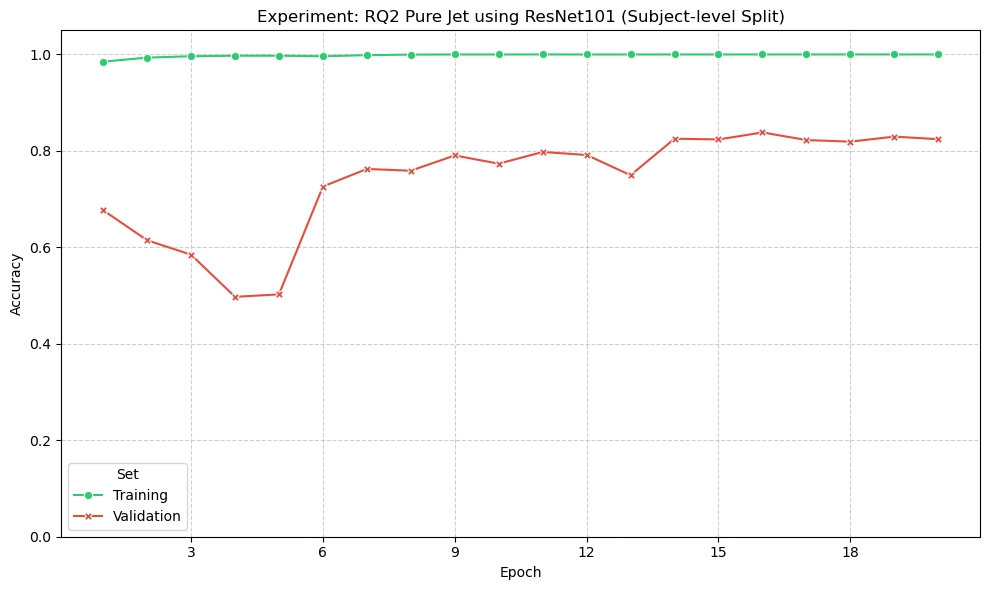

In [10]:
print(f"[{EXPERIMENT_NAME}] Starting execution...")

model, history = run_experiment(
    name=EXPERIMENT_NAME,
    train_ds=train_ds,
    val_ds=val_ds,
    class_weights=class_weights,
    epochs=EPOCHS,
)

plot_history(history, "RQ2 Pure Jet using ResNet101")

Generating predictions for Validation Set...
767/767 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step


2025-12-19 01:47:24.314250: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


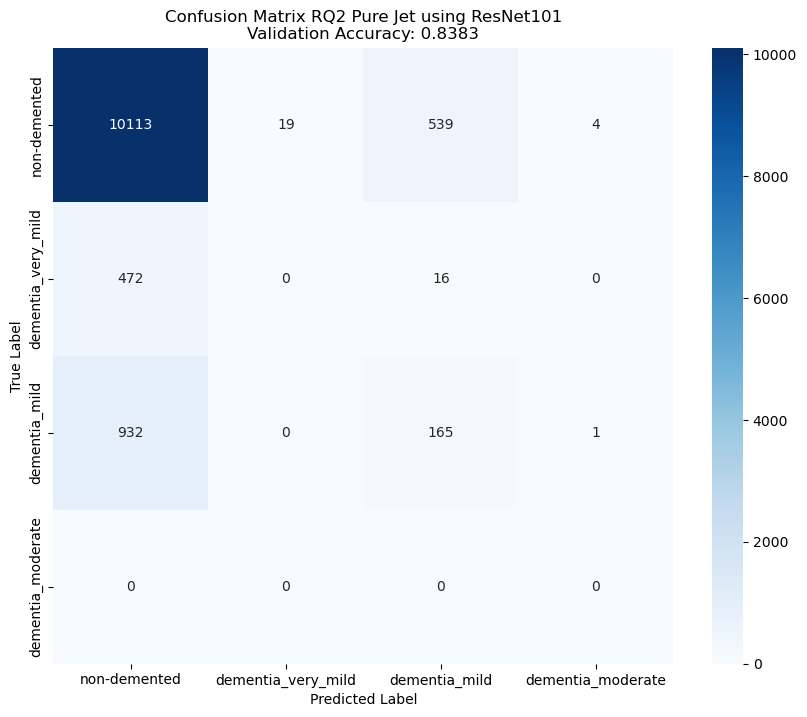


Classification Report:

                    precision    recall  f1-score   support

      non-demented       0.88      0.95      0.91     10675
dementia_very_mild       0.00      0.00      0.00       488
     dementia_mild       0.23      0.15      0.18      1098
 dementia_moderate       0.00      0.00      0.00         0

          accuracy                           0.84     12261
         macro avg       0.28      0.27      0.27     12261
      weighted avg       0.79      0.84      0.81     12261



In [ ]:
from execute_and_plot import evaluate_and_plot_cm

evaluate_and_plot_cm(model, val_ds, title_prefix="RQ2 Pure Jet using ResNet101")

It can be observed that at the 10th epoch, which was the optimal condition, the **Training Accuracy reached 99.96%**, but the **Validation Accuracy only stayed at 65.72%**. This means there is a gap of 34.24% between the two. This confirms that the model is almost incapable of making effective inferences on unseen patients. In other words, under the strict adherence to Subject-level Independence, the **Bayes Error Rate for this classification task is far greater than 0%**.

1. **Quantitative Comparison**

    Using the same ResNet-101 model architecture, hyperparameters, and preprocessing pipeline, merely changing the data splitting method resulted in an **inflated validation accuracy**.

    | **Experiment** | **Split Strategy** | **i.i.d. Assumption** | **Leakage Ratio** | **Val Accuracy (min loss)** | **Statistical Interpretation** |
    | --- | --- | --- | --- | --- | --- |
    | **Rigorous Baseline** | Subject-level | Valid | 0% | **69.42%** | True Generalization Capability |
    | **Flawed Baseline** | Slice-level | Violated | **100%** | **100%** | Memorization / Inflation |

    The **data leakage** led to a model performance inflation (or overestimation) as high as **30.58%**.

2. **Conclusion of RQ1**

    This experiment confirms the argument by **Wen et al. (2020)** that the high accuracies ($>99\%$) commonly seen on datasets like Kaggle or OASIS do not stem from the model learning pathological features, but are rather a statistical artifact caused by the **Lack of Subject-level Independence**.

    The only explanation for the inflated accuracy is that the model is doing Re-identification, rather than Disease Classification.

    The **69.42% accuracy of the Strict Baseline** represents the true lower bound of the ResNet-101 model's actual performance in a realistic clinical setting when dealing with unseen patients. This conclusion also provides a comparable baseline with room for improvement for the subsequent feature augmentation experiments in RQ2.